In [2]:
import numpy as np
# threshold : 1개의 배열당 총 element 개수, linewidth : 1줄당 문자 수
np.set_printoptions(threshold=np.inf, linewidth=np.inf) 
import pandas as pd
pd.set_option('display.max_row', 40000)
pd.set_option('display.max_column', 10000)
import matplotlib.pyplot as plt
%matplotlib inline

from os.path import join

import tensorflow as tf
# tf 2.0부터 keras는 tensorflow의 공식 API
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical

import sqlite3

import glob
import os
import csv

from sklearn.preprocessing import MinMaxScaler

## 초당 주행기록 가져오기
    1. %EventCode03_start - 6sec <= srcrec < %EventCode03_start : event03이 일어나기 직전의 주행기록
    2. 나머지 시간의 srcrec 

In [ ]:
path = "src/*" #-------------------------자신의 db파일이 있는 폴더로 수정---------------------------
file_list =  glob.glob(path)
file_list_db = [file for file in file_list if file.endswith(".db")]
print ("file_list: {}".format(file_list_db))

# EventCode03이 일어났을 당시의 초당 주행기록 가져오기
srcrec_df2 = pd.DataFrame() #연결한 db 결과 저장소
for i in range (0,len(file_list_db)):
    f = open('src/event.csv') #-------------------------자신의 event파일이 있는 폴더로 수정---------------------------
    csvReader = csv.reader(f) 
    # db연결
    conn = sqlite3.connect(file_list_db[i])
    c = conn. cursor()
    # event 테이블 유무 확인 후, 있으면 제거
    c.execute('Drop Table If Exists event')
    # 자신의 주행기록에서 발생한 event 테이블 생성
    c.execute("create table event(CAR_RECDRV_KEY integer, EVENT_CODE text, EVENT_STDT text, EVENT_ENDT text)")
    # csv 파일에서 자신의 주행기록에서 발생한 event만 추출해 insert
    for row in csvReader:
        if row[7] == "EVENT_CODE":
            continue
        sql1 = "insert into event (CAR_RECDRV_KEY, EVENT_CODE, EVENT_STDT, EVENT_ENDT) values (?,?,?,?)"
        key= int(row[1])
        # key를 추출해서 자신의 주행기록이 아니면 pass
        if key != int(file_list_db[i][4:11]): # src에 자신의 db파일이 있어야함, 경로가 다르면 인덱스 수정할 것
            continue
        code = (row[7])
        # event03 추출
        if code[-11:] != "EventCode03":
            continue
        stdt = (row[8])
        endt = (row[9])
        c.execute(sql1,(key,code,stdt,endt))
    # 트랜잭션 저장
    conn.commit()
    
    # event03이 일어나기 전의 주행기록과 그 밖의 주행기록을 분리하는 query 실행
    sql2 = 'SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcRPM,\
    SRCREC.srcAPS, SRCREC.srcTPS, SRCREC.srcEngineLoad, SRCREC.srcIntakePress, SRCREC.srcIntakeAirTemp, ifnull(EVENT_CODE, "0") AS EVENT_CODE FROM SRCREC LEFT OUTER JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s,"-6 seconds")\
     AND strftime("%Y%m%d%H%M%S",e)\
    EXCEPT \
    SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcRPM,\
    SRCREC.srcAPS, SRCREC.srcTPS, SRCREC.srcEngineLoad, SRCREC.srcIntakePress, SRCREC.srcIntakeAirTemp, EVENT_CODE FROM SRCREC LEFT JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s)\
     AND strftime("%Y%m%d%H%M%S",e)'
    query =  c.execute(sql2)
    cols = [column[0] for column in query.description]
    srcrec_df = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    #db 파일 연결 작업
    srcrec_df2 = pd.concat([srcrec_df2, srcrec_df], ignore_index=True)
    #db 연결 종료
    c.close()
    conn.close()
    #파일 연결 종료
    f.close()
srcrec_df = srcrec_df2

file_list: ['src/2875311.db', 'src/2871081.db', 'src/2872996.db', 'src/2860462.db', 'src/2879366.db', 'src/2871080.db', 'src/2859490.db', 'src/2879724.db', 'src/2875118.db', 'src/2878874.db', 'src/2877877.db', 'src/2873460.db', 'src/2878675.db', 'src/2871453.db', 'src/2871838.db', 'src/2866672.db', 'src/2879359.db', 'src/2876036.db', 'src/2861103.db', 'src/2879293.db', 'src/2862632.db', 'src/2877929.db', 'src/2859375.db', 'src/2867130.db', 'src/2873587.db', 'src/2877223.db', 'src/2866798.db', 'src/2878601.db', 'src/2878895.db', 'src/2872898.db', 'src/2878557.db', 'src/2870908.db', 'src/2878572.db', 'src/2872123.db', 'src/2873875.db', 'src/2874629.db', 'src/2874104.db', 'src/2872316.db', 'src/2877763.db', 'src/2877843.db', 'src/2877820.db', 'src/2878704.db', 'src/2874289.db', 'src/2862290.db', 'src/2873957.db', 'src/2875710.db', 'src/2881270.db', 'src/2878078.db', 'src/2860884.db', 'src/2875108.db', 'src/2874103.db', 'src/2879129.db', 'src/2878412.db', 'src/2871521.db', 'src/2872285.db'

## event03이 일어난 데이터와 그 밖의 데이터 비율 1:1로 맞추기

In [ ]:
# event03 데이터 가져오기
srcevent_df = srcrec_df[srcrec_df['EVENT_CODE'].str.contains('03')]
# event03 데이터 수만큼 비율 맞춰서 sampling
len_srcevent = len(srcevent_df.index)
srcnor_df = srcrec_df[srcrec_df['EVENT_CODE']=='0'].sample(len_srcevent)
len_srcnor = len(srcnor_df.index)
# event03이 일어난 데이터와 그 밖의 데이터 합치기
srcrec_df = pd.concat([srcevent_df,srcnor_df])
# 더 정확한 예측을 위해 주행기록을 시간순으로 정렬
srcrec_df= srcrec_df.sort_values(by=['realTime'], axis=0,ascending=True)
srcrec_df

## 주행기록을 x data와 y data로 나누기
* x data : 차량주행데이터
* y data : 이벤트 종류(%EventCode03_start-6sec < srcrec < %EventCode03_start = 1 or 나머지 = 0)

In [1]:
x_data = srcrec_df.apply(pd.to_numeric, errors='coerce')
x_data = x_data.iloc[:,2:8] # srcSpeed ~ srcIntakeAirTemp
x_data = x_data.values
x_data

NameError: name 'srcrec_df' is not defined

In [5]:
# 1번째 열 : event03 발생 X, 2번째 열 : event03 발생 
y_data = srcrec_df.values[:,9] # EVENT_CODE
y_data = pd.get_dummies(y_data).values
y_data = y_data[:,0] 

# %EventCode03 = 1, 0 = 0 으로 바꿔줌
where_0 = np.where(y_data ==0)
where_1 = np.where(y_data ==1)

y_data[where_0] = 1
y_data[where_1] = 0

# one hot encoding
#y_data = to_categorical(y_data)
y_data

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## train data와 test data로 분리 ( 7 : 3 )

In [6]:
from sklearn.model_selection import train_test_split
trnx, tstx, trny, tsty = train_test_split(x_data, y_data, test_size=0.3, random_state=111)

## x data 정규화
* train data : fit + transform
* test data : only transform

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trnx = scaler.fit_transform(trnx)
tstx = scaler.transform(tstx)

## DNN 모델 구축

In [8]:
input_shape = (x_data.shape[1], )

visible = layers.Input(shape=input_shape)
hidden1 = layers.Dense(20, activation='relu')(visible)
hidden2 = layers.Dense(20, activation='relu')(hidden1)
hidden3 = layers.Dense(20, activation='relu')(hidden2)
hidden4 = layers.Dense(20, activation='relu')(hidden3)
output = layers.Dense(1, activation='sigmoid')(hidden4) # 2 classification

mip_function = models.Model(visible, output)
mip_function.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,421
Trainable params: 1,421
Non-trainable params: 0
___________________________________________________________

## 학습

In [9]:
# multi classification 용
# mip_function.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 2 classification 용
mip_function.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
history = mip_function.fit(trnx, trny, validation_data = (tstx, tsty), batch_size = 40, epochs = 700)

Epoch 1/700
204/204 [==============================] - 2s 6ms/step - loss: 0.6680 - accuracy: 0.5629 - val_loss: 0.5584 - val_accuracy: 0.6903
Epoch 2/700
204/204 [==============================] - 1s 3ms/step - loss: 0.5561 - accuracy: 0.6925 - val_loss: 0.5310 - val_accuracy: 0.7144
Epoch 3/700
204/204 [==============================] - 1s 3ms/step - loss: 0.5367 - accuracy: 0.7098 - val_loss: 0.5209 - val_accuracy: 0.7284
Epoch 4/700
204/204 [==============================] - 0s 2ms/step - loss: 0.5343 - accuracy: 0.7160 - val_loss: 0.5131 - val_accuracy: 0.7316
Epoch 5/700
204/204 [==============================] - 0s 2ms/step - loss: 0.5199 - accuracy: 0.7296 - val_loss: 0.5058 - val_accuracy: 0.7370
Epoch 6/700
204/204 [==============================] - 0s 1ms/step - loss: 0.5027 - accuracy: 0.7397 - val_loss: 0.5052 - val_accuracy: 0.7413
Epoch 7/700
204/204 [==============================] - 0s 1ms/step - loss: 0.5100 - accuracy: 0.7382 - val_loss: 0.4999 - val_accuracy: 0.7465

Epoch 58/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4439 - accuracy: 0.7825 - val_loss: 0.4723 - val_accuracy: 0.7748
Epoch 59/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4515 - accuracy: 0.7796 - val_loss: 0.4743 - val_accuracy: 0.7743
Epoch 60/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4440 - accuracy: 0.7776 - val_loss: 0.4756 - val_accuracy: 0.7737
Epoch 61/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4473 - accuracy: 0.7835 - val_loss: 0.4732 - val_accuracy: 0.7740
Epoch 62/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4373 - accuracy: 0.7905 - val_loss: 0.4757 - val_accuracy: 0.7671
Epoch 63/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4463 - accuracy: 0.7818 - val_loss: 0.4755 - val_accuracy: 0.7726
Epoch 64/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4383 - accuracy: 0.7867 - val_loss: 0.4747 - val_accuracy:

Epoch 115/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4433 - accuracy: 0.7850 - val_loss: 0.4826 - val_accuracy: 0.7748
Epoch 116/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4203 - accuracy: 0.8012 - val_loss: 0.4760 - val_accuracy: 0.7783
Epoch 117/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4185 - accuracy: 0.8050 - val_loss: 0.4765 - val_accuracy: 0.7771
Epoch 118/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4162 - accuracy: 0.8081 - val_loss: 0.4810 - val_accuracy: 0.7734
Epoch 119/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4310 - accuracy: 0.8033 - val_loss: 0.4780 - val_accuracy: 0.7771
Epoch 120/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4203 - accuracy: 0.8073 - val_loss: 0.4819 - val_accuracy: 0.7734
Epoch 121/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4190 - accuracy: 0.8022 - val_loss: 0.4801 - val_ac

204/204 [==============================] - 1s 3ms/step - loss: 0.3984 - accuracy: 0.8189 - val_loss: 0.4825 - val_accuracy: 0.7840
Epoch 228/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4078 - accuracy: 0.8104 - val_loss: 0.4837 - val_accuracy: 0.7760
Epoch 229/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4054 - accuracy: 0.8162 - val_loss: 0.4842 - val_accuracy: 0.7843
Epoch 230/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4060 - accuracy: 0.8108 - val_loss: 0.4883 - val_accuracy: 0.7711
Epoch 231/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4147 - accuracy: 0.8105 - val_loss: 0.4864 - val_accuracy: 0.7789
Epoch 232/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4163 - accuracy: 0.8064 - val_loss: 0.4887 - val_accuracy: 0.7789
Epoch 233/700
204/204 [==============================] - 1s 3ms/step - loss: 0.4103 - accuracy: 0.8100 - val_loss: 0.4887 - val_accuracy: 0.7817

204/204 [==============================] - 0s 2ms/step - loss: 0.3985 - accuracy: 0.8179 - val_loss: 0.4962 - val_accuracy: 0.7817
Epoch 340/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3944 - accuracy: 0.8210 - val_loss: 0.4995 - val_accuracy: 0.7809
Epoch 341/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3859 - accuracy: 0.8236 - val_loss: 0.4973 - val_accuracy: 0.7769
Epoch 342/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3947 - accuracy: 0.8169 - val_loss: 0.4980 - val_accuracy: 0.7766
Epoch 343/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3928 - accuracy: 0.8180 - val_loss: 0.4987 - val_accuracy: 0.7846
Epoch 344/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3972 - accuracy: 0.8192 - val_loss: 0.4946 - val_accuracy: 0.7812
Epoch 345/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3939 - accuracy: 0.8182 - val_loss: 0.4965 - val_accuracy: 0.7803

204/204 [==============================] - 1s 3ms/step - loss: 0.3781 - accuracy: 0.8261 - val_loss: 0.5131 - val_accuracy: 0.7737
Epoch 452/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3726 - accuracy: 0.8338 - val_loss: 0.5159 - val_accuracy: 0.7763
Epoch 453/700
204/204 [==============================] - 0s 2ms/step - loss: 0.4002 - accuracy: 0.8153 - val_loss: 0.5064 - val_accuracy: 0.7777
Epoch 454/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3795 - accuracy: 0.8248 - val_loss: 0.5210 - val_accuracy: 0.7685
Epoch 455/700
204/204 [==============================] - 0s 1ms/step - loss: 0.3847 - accuracy: 0.8193 - val_loss: 0.5119 - val_accuracy: 0.7817
Epoch 456/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3881 - accuracy: 0.8205 - val_loss: 0.5228 - val_accuracy: 0.7777
Epoch 457/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.8355 - val_loss: 0.5145 - val_accuracy: 0.7760

204/204 [==============================] - 1s 3ms/step - loss: 0.3618 - accuracy: 0.8315 - val_loss: 0.5270 - val_accuracy: 0.7806
Epoch 564/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3658 - accuracy: 0.8395 - val_loss: 0.5306 - val_accuracy: 0.7783
Epoch 565/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3764 - accuracy: 0.8280 - val_loss: 0.5357 - val_accuracy: 0.7720
Epoch 566/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3802 - accuracy: 0.8251 - val_loss: 0.5363 - val_accuracy: 0.7809
Epoch 567/700
204/204 [==============================] - 0s 2ms/step - loss: 0.3717 - accuracy: 0.8271 - val_loss: 0.5221 - val_accuracy: 0.7814
Epoch 568/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3772 - accuracy: 0.8258 - val_loss: 0.5341 - val_accuracy: 0.7791
Epoch 569/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3643 - accuracy: 0.8366 - val_loss: 0.5271 - val_accuracy: 0.7786

204/204 [==============================] - 1s 3ms/step - loss: 0.3554 - accuracy: 0.8404 - val_loss: 0.5383 - val_accuracy: 0.7751
Epoch 676/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3587 - accuracy: 0.8366 - val_loss: 0.5434 - val_accuracy: 0.7766
Epoch 677/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3612 - accuracy: 0.8369 - val_loss: 0.5581 - val_accuracy: 0.7766
Epoch 678/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3673 - accuracy: 0.8296 - val_loss: 0.5448 - val_accuracy: 0.7800
Epoch 679/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3623 - accuracy: 0.8319 - val_loss: 0.5485 - val_accuracy: 0.7746
Epoch 680/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3584 - accuracy: 0.8387 - val_loss: 0.5500 - val_accuracy: 0.7774
Epoch 681/700
204/204 [==============================] - 1s 3ms/step - loss: 0.3643 - accuracy: 0.8348 - val_loss: 0.5478 - val_accuracy: 0.7714

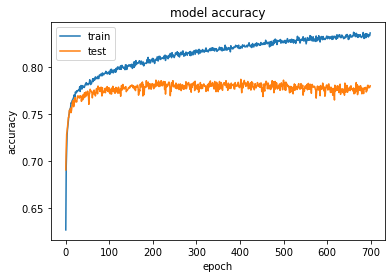

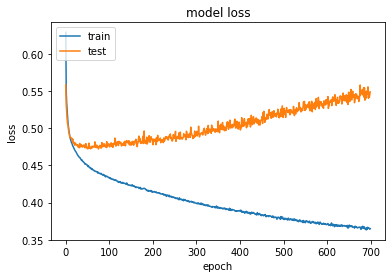

0.7800057530403137
0.7868805527687073


In [10]:
# summerize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summerize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test data 마지막 정확도
print(history.history['val_accuracy'][-1])
# test data 가장 높은 정확도
print(np.max(history.history['val_accuracy']))

## 예측

In [11]:
# 학습된 모델인 mip_function에 test 데이터를 입력하면 model이 예측한 event03 유무가 나옵니다.
# 해당 유무를 실제 event03유무와 비교하여 출력합니다.
# y_pred = mip_function.predict(tstx, batch_size=40)
# a = 0
# b = 0
# c = 0
# d = 0
# for i in range(len(y_pred[:,0])) :
#     if y_pred[i,0] > y_pred[i,1] : # event03 발생 X
#         if tsty[i,1] == 0 :
#             #print("실제 : 0, 예측 : 0")
#             a = a + 1
#         else :
#             #print("실제 : 1, 예측 : 0")
#             b = b + 1
#     else :
#         if tsty[i,1] == 1 : # event03 발생 
#             #print("실제 : 1, 예측 : 1")
#             c = c + 1
#         else :
#             #print("실제 : 0, 예측 : 1")
#             d = d+ 1
# print("실제 : 0, 예측 : 0 -> ", a)
# print("실제 : 1, 예측 : 0 -> ", b)
# print("실제 : 1, 예측 : 1 -> ", c)
# print("실제 : 0, 예측 : 1 -> ", d)
# print("전체데이터 개수 : ", len(y_pred[:,0]))